In [140]:
#TEAM 17 (PRIVACY PRESERVATION OF PHI DATA USING K-ANONYMITY, L-DIVERSITY AND T-CLOSENESS)
#Jayant Bishnoi 20BCT0057
#Lokesh Rai 20BCT0286
#Chinmay Das 20BCI0172

import pandas as pd

In [141]:
names = (
    'age',
    'workclass', 
    'fnlwgt', 
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
)

categorical = set((
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'sex',
    'native-country',
    'race',
    'income',
))
df = pd.read_csv("adult.all.txt", sep=", ", header=None, names=names, index_col=False, engine='python');# We load the data using Pandas


In [142]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50k
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50k
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50k
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50k
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50k


In [143]:
for name in categorical:
    df[name] = df[name].astype('category')

In [144]:
def get_spans(df, partition, scale=None):
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

In [145]:
full_spans = get_spans(df, df.index)
full_spans

{'age': 73,
 'workclass': 9,
 'fnlwgt': 1478115,
 'education': 16,
 'education-num': 15,
 'marital-status': 7,
 'occupation': 15,
 'relationship': 6,
 'race': 5,
 'sex': 2,
 'capital-gain': 99999,
 'capital-loss': 4356,
 'hours-per-week': 98,
 'native-country': 42,
 'income': 2}

In [146]:
def split(df, partition, column):
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

In [147]:
def is_k_anonymous(df, partition, sensitive_column, k=4):
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions

In [148]:
feature_columns = ['age', 'education-num']
sensitive_column = 'income'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)

In [149]:
# we get the number of partitions that were created
len(finished_partitions)

481

In [150]:
import matplotlib.pylab as pl
import matplotlib.patches as patches

In [151]:
def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

In [152]:
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2]
rects = get_partition_rects(df, finished_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

In [153]:
rects[:10]

[((17.0, 7.0), (18.0, 9.0)),
 ((18.0, 7.0), (20.0, 9.0)),
 ((21.0, 10.0), (22.0, 11.0)),
 ((25.0, 10.0), (27.0, 11.0)),
 ((37.0, 9.0), (39.0, 10.0)),
 ((37.0, 10.0), (38.0, 13.0)),
 ((41.0, 10.0), (43.0, 13.0)),
 ((39.0, 13.0), (41.0, 16.0)),
 ((46.0, 10.0), (48.0, 13.0)),
 ((46.0, 13.0), (48.0, 16.0))]

In [154]:
def plot_rects(df, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
    ax.set_xlim(*get_bounds(df, column_x, indexes))
    ax.set_ylim(*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)

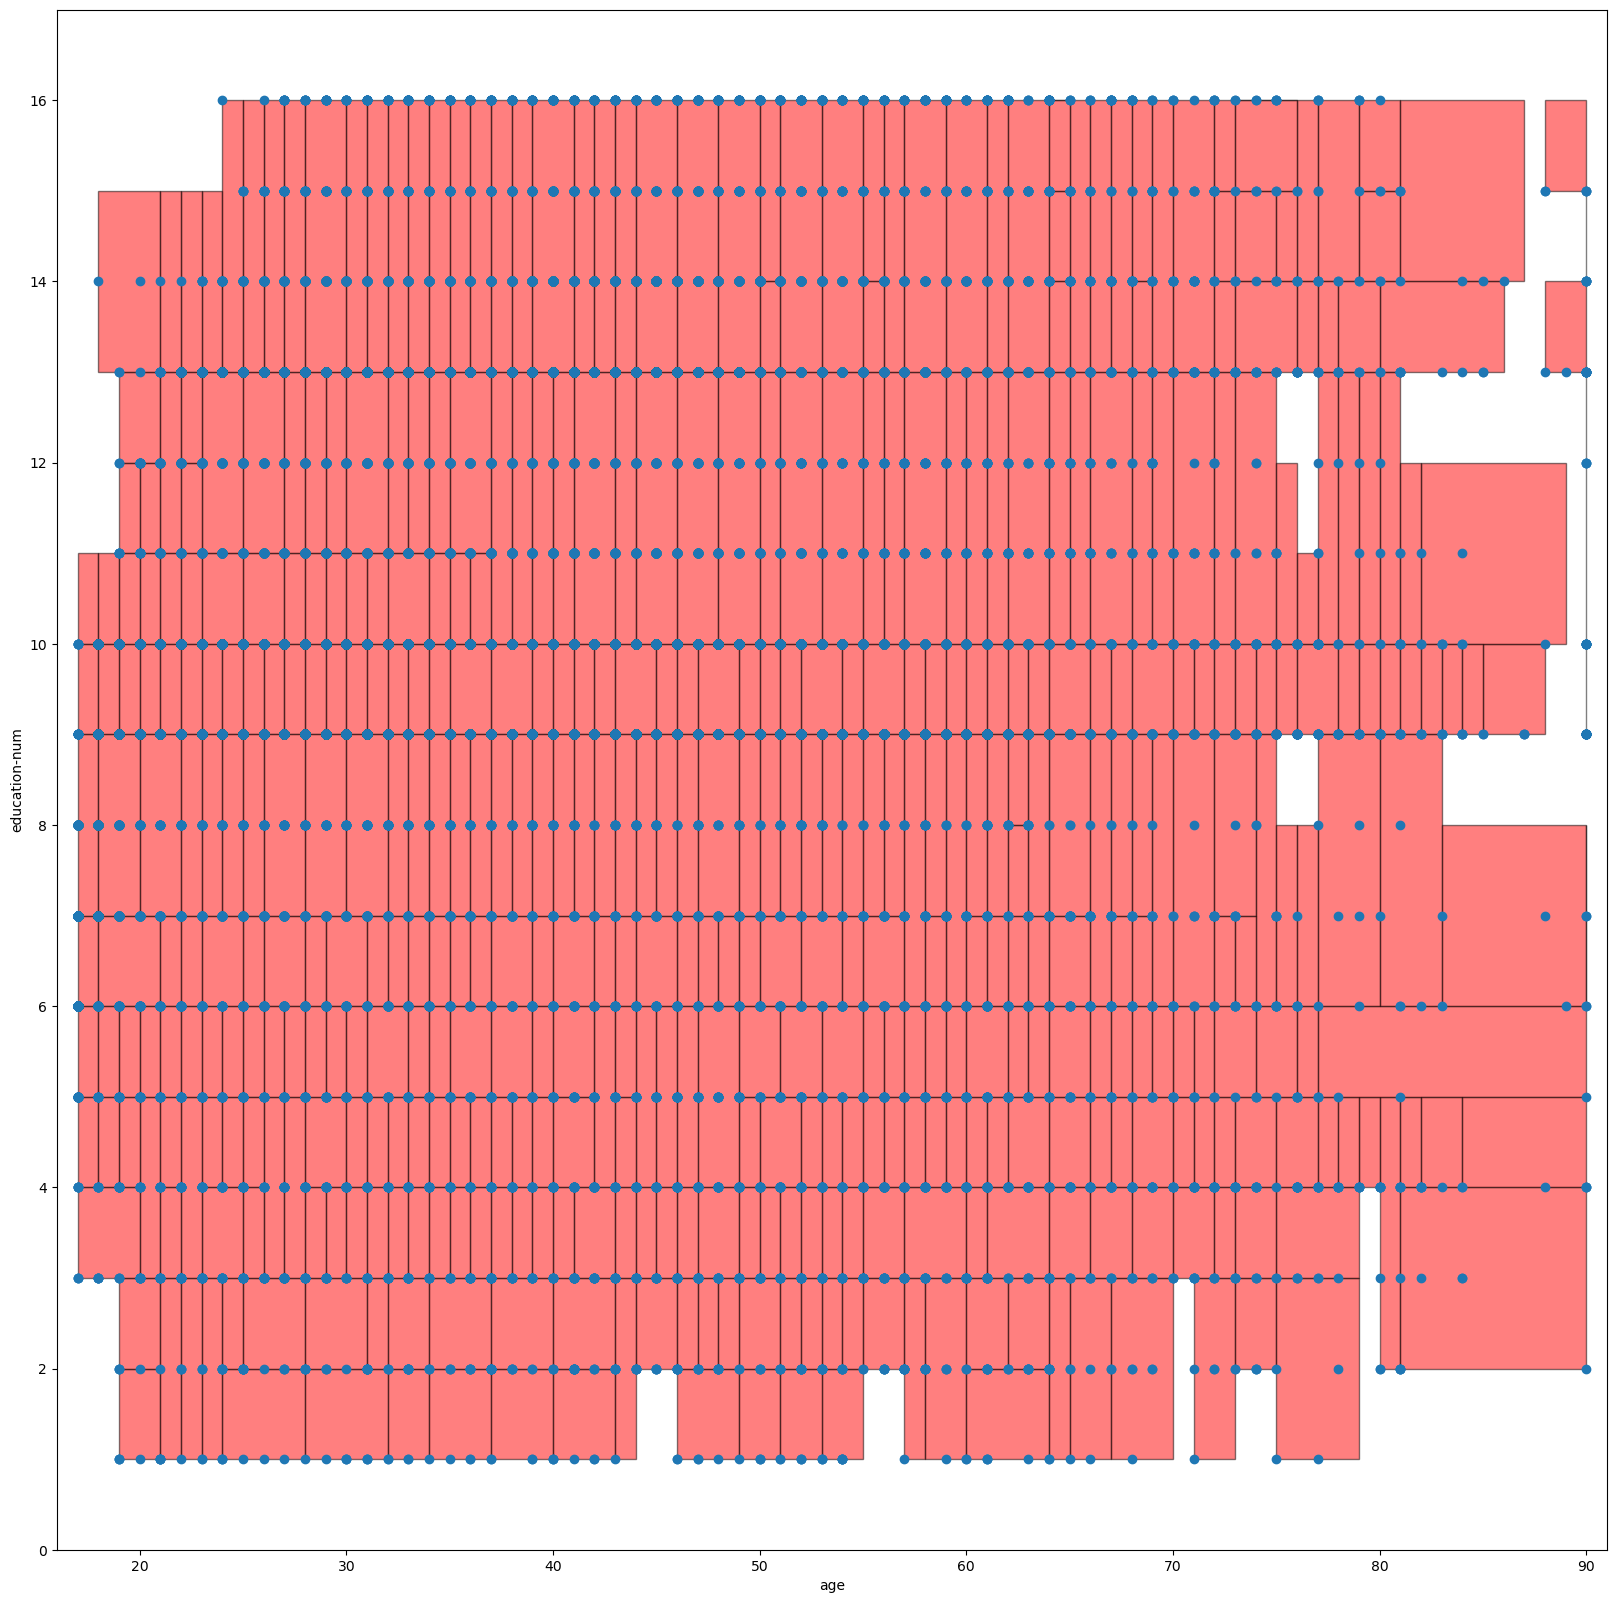

In [155]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
pl.show()

In [156]:
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    #return [series.mean()]
    minimum = series.min()
    maximum = series.max()
    if maximum == minimum:
        string = str(maximum)
    else:
        string = f"{minimum}-{maximum}"
    return [string]

In [157]:
def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        df2=grouped_columns.to_frame()
        grouped_columns=pd.DataFrame(df2.values.T,columns=df2.index)
        values = grouped_columns.iloc[0].to_dict()
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count,

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)

In [158]:
dfn = build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...


In [159]:
dfn = dfn.sort_values(by=['count'],ascending=False)
print(dfn.head())

        age education-num income  count
41  [35-36]           [9]  <=50k    789
50  [23-24]          [10]  <=50k    695
7   [37-38]           [9]  <=50k    671
47     [20]          [10]  <=50k    616
3      [21]          [10]  <=50k    568


In [124]:
def diversity(df, partition, column):
    return len(df[column][partition].unique())

def is_l_diverse(df, partition, sensitive_column, l=2):
    return diversity(df, partition, sensitive_column) >= l

In [125]:
finished_l_diverse_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous(*args) and is_l_diverse(*args))

In [126]:
len(finished_l_diverse_partitions)

303

In [127]:
column_x, column_y = feature_columns[:2]
l_diverse_rects = get_partition_rects(df, finished_l_diverse_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

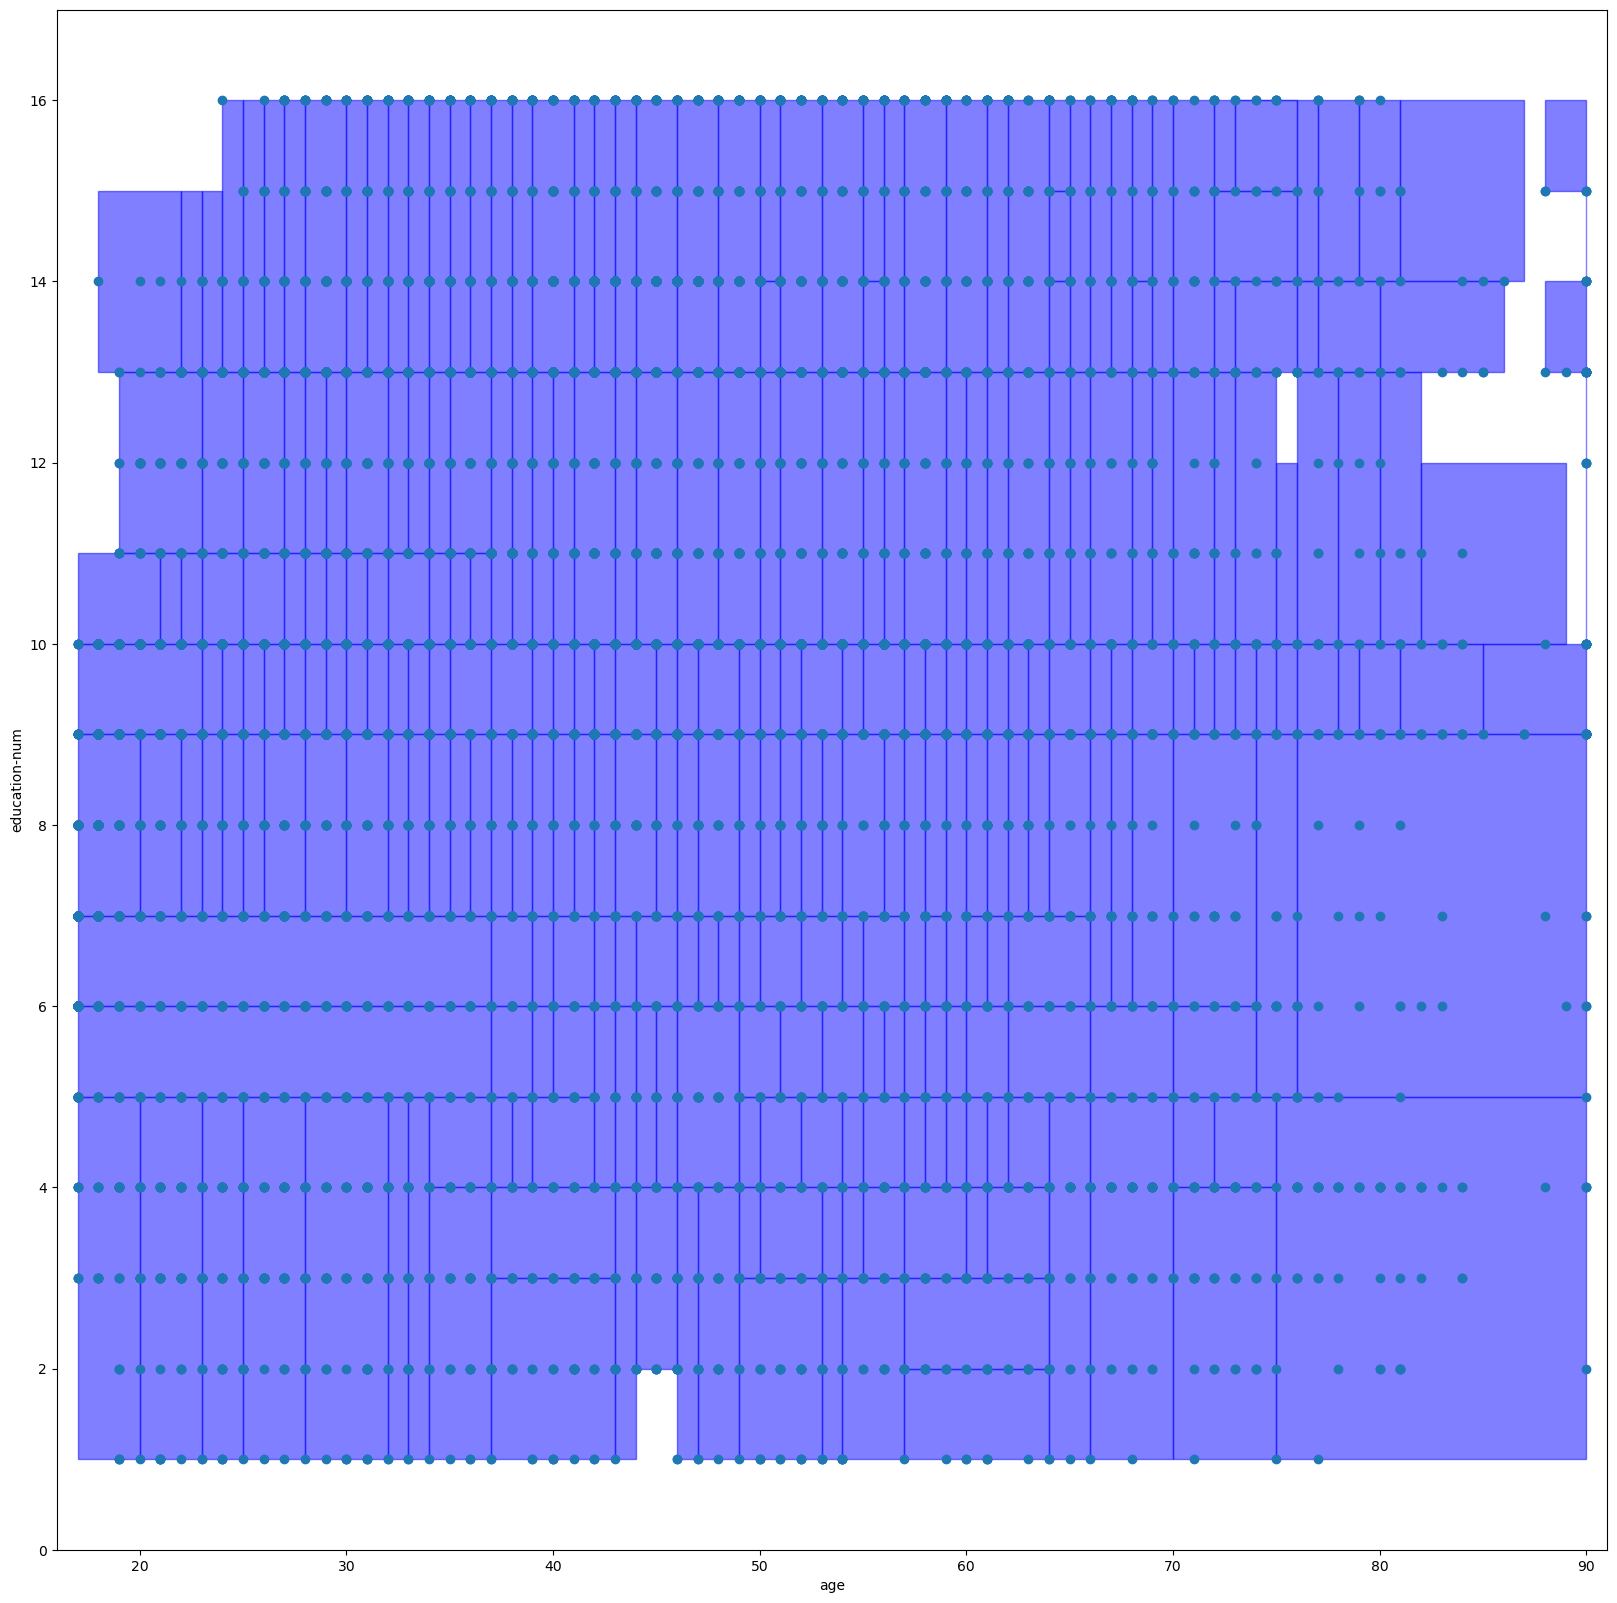

In [128]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, l_diverse_rects, column_x, column_y, edgecolor='b', facecolor='b')
pl.scatter(df[column_x], df[column_y])
pl.show()

In [129]:
dfl = build_anonymized_dataset(df, finished_l_diverse_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...


In [130]:
dfl = dfl.sort_values(by=['count'],ascending=False)
print(dfl.head())

        age education-num income  count
2   [17-22]           [9]  <=50k   1707
4   [17-20]          [10]  <=50k   1301
48  [35-36]           [9]  <=50k    789
0   [17-19]         [7-8]  <=50k    785
8   [17-36]           [6]  <=50k    727


In [131]:
global_freqs = {}
total_count = float(len(df))
group_counts = df.groupby(sensitive_column)[sensitive_column].agg('count')
for value, count in group_counts.to_dict().items():
    p = count/total_count
    global_freqs[value] = p

In [132]:
global_freqs

{'<=50k': 0.7607182343065395, '>50k': 0.23928176569346055}

In [133]:
def t_closeness(df, partition, column, global_freqs):
    total_count = float(len(partition))
    d_max = None
    group_counts = df.loc[partition].groupby(column)[column].agg('count')
    for value, count in group_counts.to_dict().items():
        p = count/total_count
        d = abs(p-global_freqs[value])
        if d_max is None or d > d_max:
            d_max = d
    return d_max


def is_t_close(df, partition, sensitive_column, global_freqs, p=0.15):
    if not sensitive_column in categorical:
        raise ValueError("this method only works for categorical values")
    return t_closeness(df, partition, sensitive_column, global_freqs) <= p

In [134]:
# Let's apply this to our dataset
finished_t_close_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous(*args) and is_t_close(*args, global_freqs))

In [135]:
len(finished_t_close_partitions)

16

In [136]:
dft = build_anonymized_dataset(df, finished_t_close_partitions, feature_columns, sensitive_column)

Finished 1 partitions...


In [137]:
dft = dft.sort_values(by=['count'],ascending=False)
print(dft.head())

        age education-num income  count
0   [17-36]        [1-16]  <=50k  20746
2   [47-90]        [9-16]  <=50k   6915
3   [47-90]        [9-16]   >50k   4357
1   [17-36]        [1-16]   >50k   2948
12  [39-40]        [1-16]  <=50k   1576


In [138]:
column_x, column_y = feature_columns[:2]
t_close_rects = get_partition_rects(df, finished_t_close_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

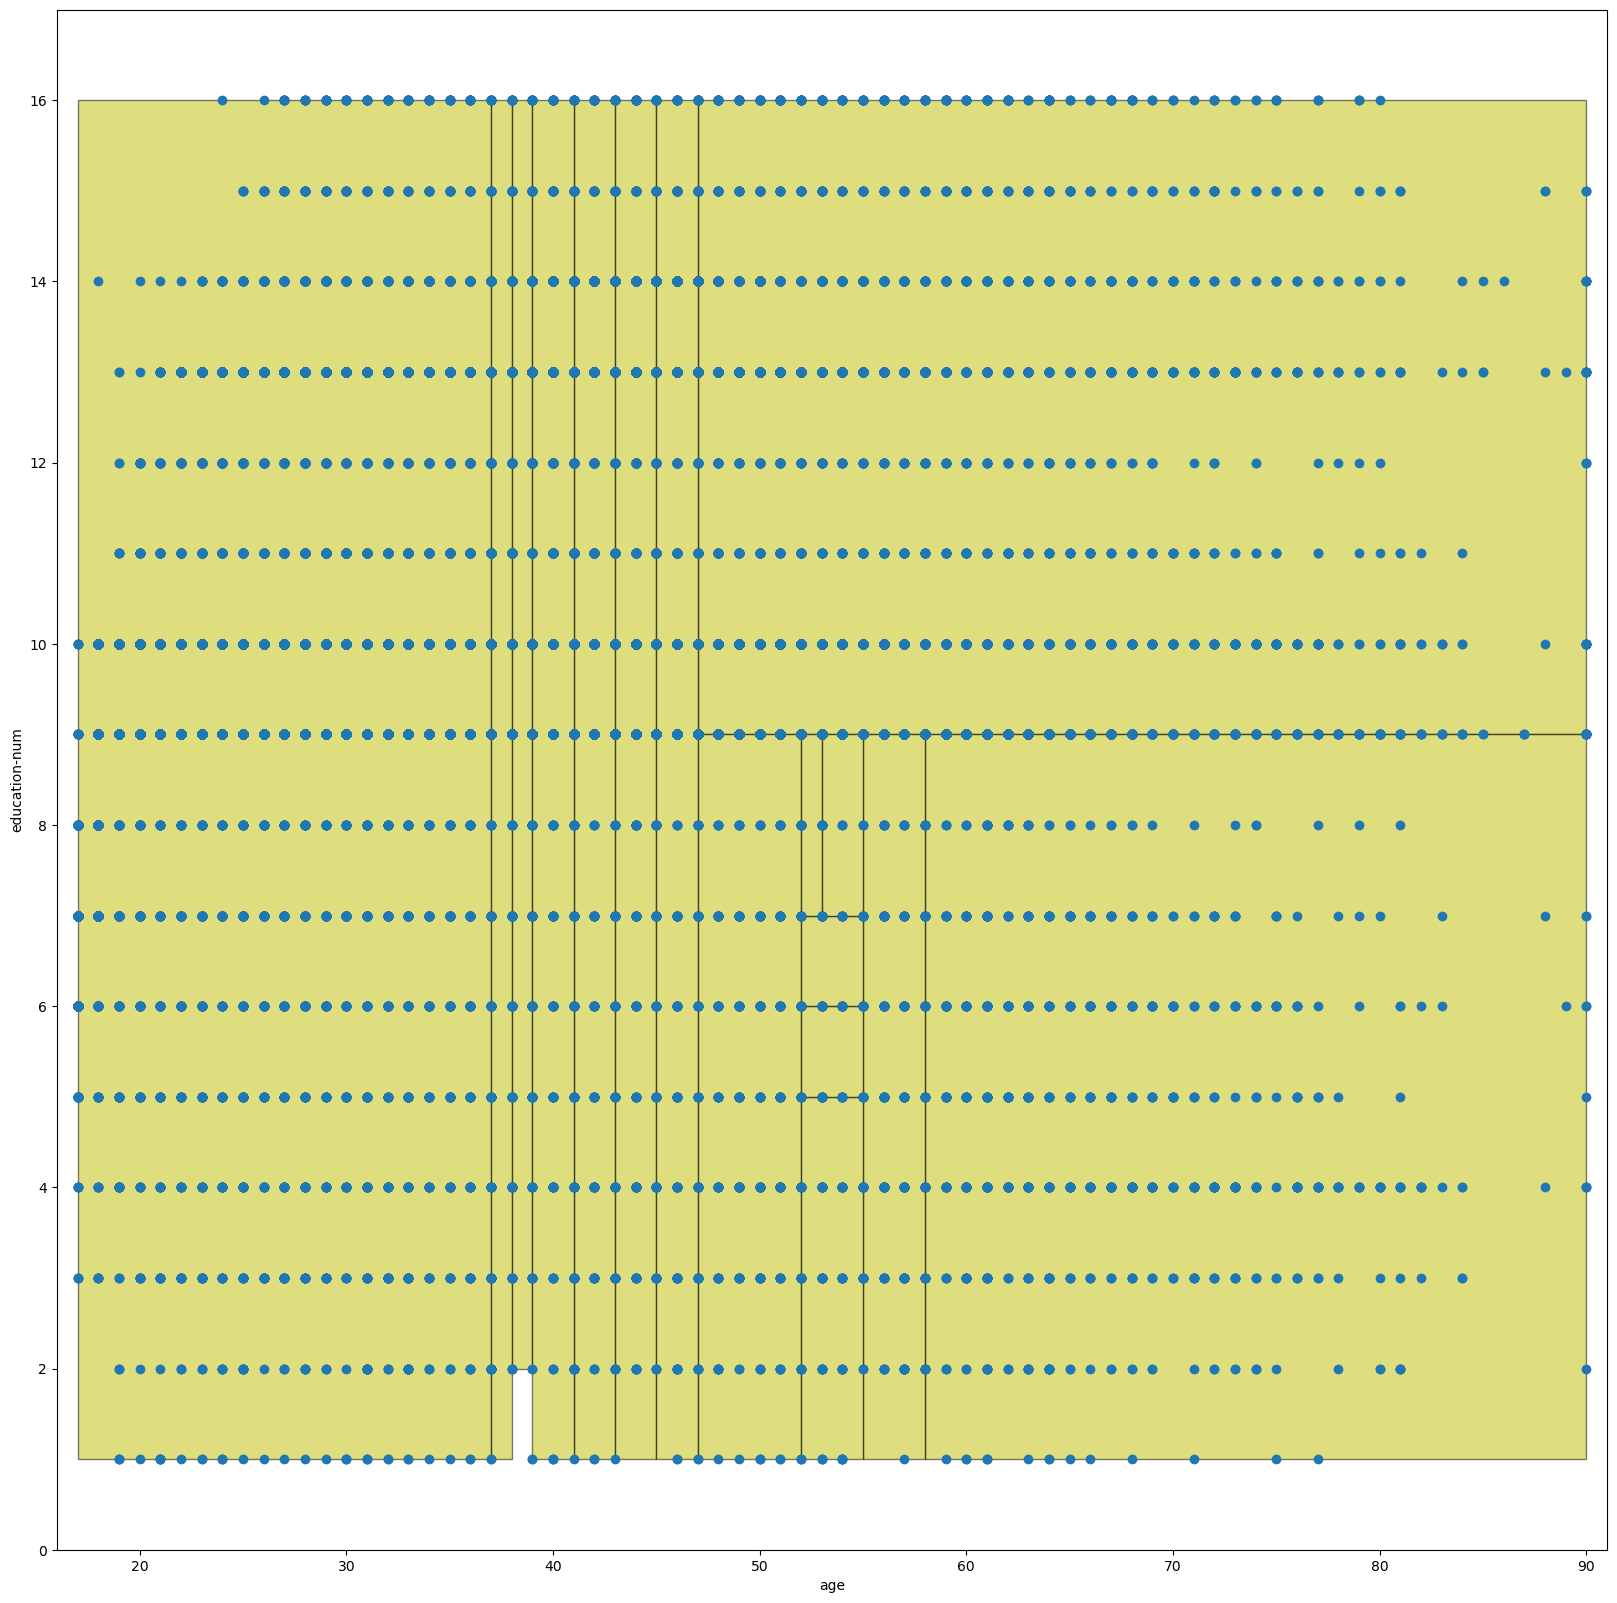

In [139]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, t_close_rects, column_x, column_y, edgecolor='k', facecolor='y')
pl.scatter(df[column_x], df[column_y])
pl.show()